## We multiplex 4 donors and extract the confident cells for each cluster (p>0.9), while removing doublets (p>0.9).
## We then run lineage clustering for each separate donor, testing lineages of 2-4 .
This shows that there is still more to be gained.

Version notes: 
- This does not plot AF as square roots
- This only looks at 2-4 clones, in which it seems like it should be more
- The saving of the elbow plots are still not saving properly

In [1]:
pwd

'/data2/mito_lineage/Analysis/multiplex'

In [2]:
# Parameters
INDIR=""
N_DONORS=4
OUTDIR=""

In [3]:
INDIR="data/jan21_2021/chrM/pseudo/minC200_minAF0.01/numC25000_ispropFalse"
OUTDIR= "data/jan21_2021/chrM/pseudo/minC200_minAF0.01/numC25000_ispropFalse/flt3"
N_DONORS=4 


In [4]:
from os.path import join, exists, dirname
from glob import glob
import mplh.cluster_help as ch
import os

fig_utils from mplh
here


In [5]:
AD_F = join(INDIR, "cellSNP.tag.AD.mtx")
DP_F = join(INDIR, "cellSNP.tag.DP.mtx")
cell_inds_names = join(INDIR,"cell_indices_*.txt")

# Using vireo for clonal reconstruction - mitochondrial mutations

The mitochondrial mutations data set is extracted from [Ludwig et al, Cell, 2019](https://doi.org/10.1016/j.cell.2019.01.022), the 9 variants used here are from Supp Fig. 2F (and main Fig. 2F).

For clonal reconstruction, we are using the core class `vireoSNP.Vireo` with multiple initializations

In [6]:
import vireoSNP
import numpy as np
from scipy import sparse
from scipy.io import mmread
import matplotlib.pyplot as plt

print(vireoSNP.__version__)

import pandas as pd
import seaborn as sns


0.4.2


In [7]:
np.set_printoptions(formatter={'float': lambda x: format(x, '.5f')})

In [8]:
AD = mmread(AD_F).tocsc()
DP = mmread(DP_F).tocsc()

AD_shape = AD.todense().shape

In [9]:
# cells = pd.read_csv(join(dirname(AD_F), "cellSNP.samples.tsv"), header=None)
# cells

## New implementation in v0.3.0

In [10]:
from vireoSNP import Vireo

Note, there are a few key parameters:

* `n_donor`: it means number of clones here, but you need to determine yourself. You can choose the one with highest ELBO (see next section)
* `n_GT`: number of different genotype. For somatic mutations, we could assume that there are only two, namely present or absent
* `is_theta_ASE`: whether allelic ratio is variant specific. For mitochondrial mutations, we choose True as allelic ratio can different from variant to variant

### Multiple initialization is needed to avoid local optima

In [11]:
np.random.seed(1)

n_initials = 50
_models_all = []
for i in range(n_initials):
    _modelCA = Vireo(n_var=AD_shape[0], n_cell=AD_shape[1], n_donor=N_DONORS, n_GT=2,
                     fix_beta_sum=False, ASE_mode=True)
    _modelCA.set_prior(beta_mu_prior=np.array([[0.01, 0.5]]))
    _modelCA.fit(AD, DP, min_iter=20, verbose=False, delay_fit_theta=0)
    _models_all.append(_modelCA)

In [12]:
## Choose the model giving highest ELBO
_idx = np.argmax([x.ELBO_[-1] for x in _models_all])
modelCA = _models_all[_idx]
_losses = modelCA.ELBO_

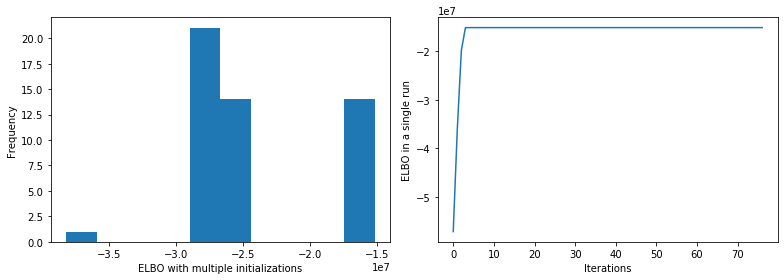

In [13]:
fig = plt.figure(figsize=(11, 4))
plt.subplot(1, 2, 1)
plt.hist([x.ELBO_[-1] for x in _models_all])
plt.ylabel("Frequency")
plt.xlabel("ELBO with multiple initializations")

plt.subplot(1, 2, 2)
plt.plot(_losses)
plt.xlabel("Iterations")
plt.ylabel("ELBO in a single run")

plt.tight_layout()
plt.show()

In [14]:
print(modelCA.beta_mu),
print(modelCA.beta_sum)

[[0.87435 0.02785]
 [0.89499 0.03081]
 [0.04013 0.87782]
 [0.86837 0.02841]
 [0.04364 0.91458]
 [0.91714 0.04448]
 [0.02849 0.87932]
 [0.00163 0.17780]
 [0.02795 0.88338]
 [0.01101 0.01495]
 [0.02968 0.03632]
 [0.01040 0.01393]
 [0.02317 0.04662]
 [0.01059 0.02773]
 [0.66370 0.11840]
 [0.01142 0.01205]
 [0.01415 0.01514]
 [0.01338 0.01451]
 [0.01194 0.01208]
 [0.01721 0.01882]
 [0.01019 0.01109]
 [0.01610 0.01695]
 [0.01670 0.01691]
 [0.01095 0.01168]
 [0.01059 0.01117]
 [0.01188 0.01200]
 [0.90722 0.04053]
 [0.01441 0.01597]
 [0.01956 0.02075]
 [0.02016 0.02238]
 [0.09796 0.00277]
 [0.02932 0.04306]
 [0.00885 0.01525]
 [0.01957 0.03989]
 [0.01077 0.02176]
 [0.00829 0.01666]
 [0.04695 0.00826]
 [0.00656 0.02447]
 [0.01048 0.02517]
 [0.00757 0.02200]
 [0.00825 0.01777]
 [0.02940 0.87448]
 [0.03040 0.88683]
 [0.01904 0.01987]
 [0.01089 0.01100]
 [0.88464 0.02927]
 [0.02960 0.87490]
 [0.03880 0.89781]
 [0.88768 0.03028]
 [0.01346 0.01400]
 [0.01194 0.01205]
 [0.44270 0.44366]
 [0.04471 0.

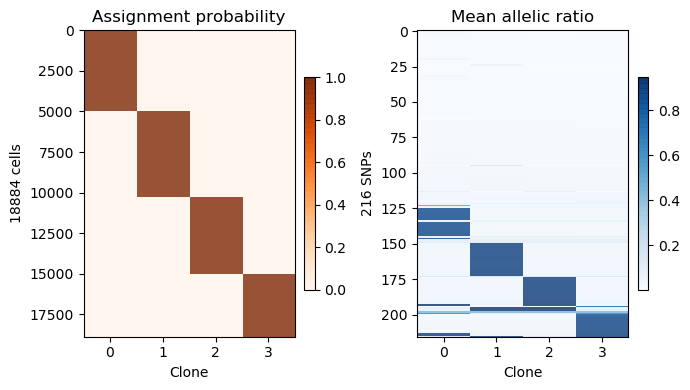

In [15]:
import matplotlib.pyplot as plt
from vireoSNP.plot.base_plot import heat_matrix

fig = plt.figure(figsize=(7, 4), dpi=100)
plt.subplot(1, 2, 1)
im = heat_matrix(modelCA.ID_prob, cmap="Oranges", alpha=0.8,
                 display_value=False, row_sort=True)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title("Assignment probability")
plt.xlabel("Clone")
plt.ylabel("%d cells" %(modelCA.n_cell))
plt.xticks(range(modelCA.n_donor))


plt.subplot(1, 2, 2)
AF_SNPs = np.sum(modelCA.GT_prob * 
                 np.expand_dims(modelCA.beta_mu, 1), axis=2)
im = heat_matrix(AF_SNPs, cmap="Blues", alpha=0.8, 
                 display_value=False, row_sort=True)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title("Mean allelic ratio")
plt.xlabel("Clone")
plt.ylabel("%d SNPs" %(modelCA.n_var))
plt.xticks(range(modelCA.n_donor))

plt.tight_layout()
plt.savefig(join(OUTDIR, "donors_multiplex.png"))
plt.show()


## Add in cell IDs

cell inds ['data/jan21_2021/chrM/pseudo/minC200_minAF0.01/numC25000_ispropFalse/cell_indices_0.txt', 'data/jan21_2021/chrM/pseudo/minC200_minAF0.01/numC25000_ispropFalse/cell_indices_1.txt']
data/jan21_2021/chrM/pseudo/minC200_minAF0.01/numC25000_ispropFalse/cell_indices_0.txt
data/jan21_2021/chrM/pseudo/minC200_minAF0.01/numC25000_ispropFalse/cell_indices_1.txt


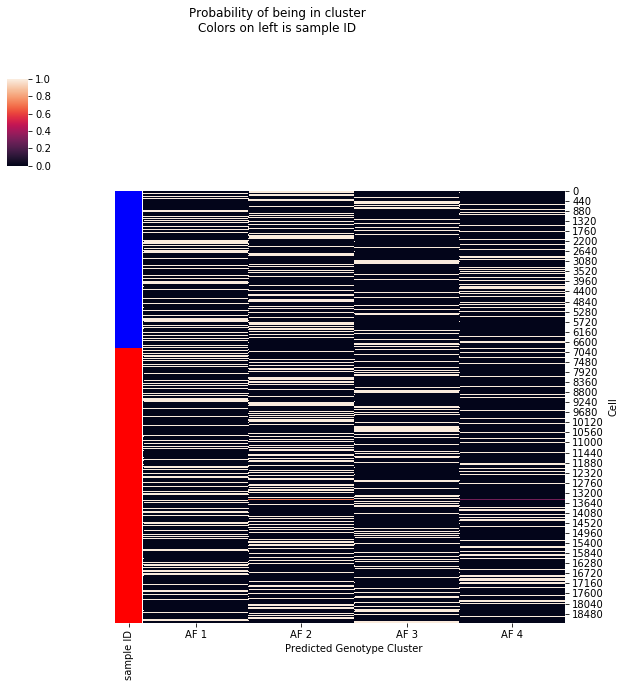

In [20]:

in_cell_f = glob(cell_inds_names)
print('cell inds', in_cell_f)
in_cell_names = []
cell_map = {}
for curr_cell_f in in_cell_f:
    print(curr_cell_f)
    with open(curr_cell_f, "r") as f:
        count = 0
        lines = []
        for line in f: 
            if count == 0:
                curr_f = line.strip()
            else:
                lines.append(line.strip().split(','))
            count += 1
    curr_df = pd.DataFrame(lines[1:], columns=lines[0])
    cell_map[curr_f] = curr_df["new index"].astype(int).values
    in_cell_names.append(curr_f)
    
max_v = 0
for i in in_cell_names:
    max_v = max(max_v, max(cell_map[i]))
    
# create index map:
cell_ind_map = {}
count = 0
for i in in_cell_names: 
    cell_ind_map[i] = count
    count += 1

cell_inds = -1*np.ones(max_v)
for i in in_cell_names:
    cell_inds[cell_map[i]-1] = cell_ind_map[i] #cell_map[i]

sample_names = {0: "Control", 1:"Flt3"}
sample_colors = pd.DataFrame([sample_names[x] for x in cell_inds], columns=["sample ID"])
colors = {0:"blue", 1:"red"}
cell_colors = [colors[x] for x in cell_inds]
cell_colors = pd.Series(cell_colors, name="sample ID")
g = sns.clustermap(data=pd.DataFrame(modelCA.ID_prob, columns=[f"AF {x+1}" for x in np.arange(modelCA.ID_prob.shape[1])]), row_cluster=False, col_cluster=False,
              row_colors=cell_colors)
#plt.ylabel("Cell")
#plt.xlabel("Predicted Genotype Cluster")


g.fig.suptitle("Probability of being in cluster\nColors on left is sample ID")
g.ax_heatmap.set_xlabel("Predicted Genotype Cluster")
g.ax_heatmap.set_ylabel("Cell")

#plt.savefig("pseudo_multiplex_with_cellIDs.png")

array([   34,    35,    49, ..., 18835, 18857, 18880])

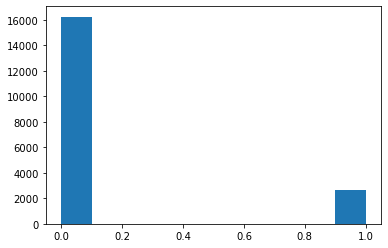

In [21]:
doublet_thresh = 0.9

plt.hist(modelCA.predict_doublet(AD, DP, update_GT=False, update_ID=False)[0].sum(axis=1))

doublet_prob = modelCA.predict_doublet(AD, DP, update_GT=False, update_ID=False)[0].sum(axis=1)
low_conf_cells = np.flatnonzero(doublet_prob > doublet_thresh)
low_conf_cells

cmap None


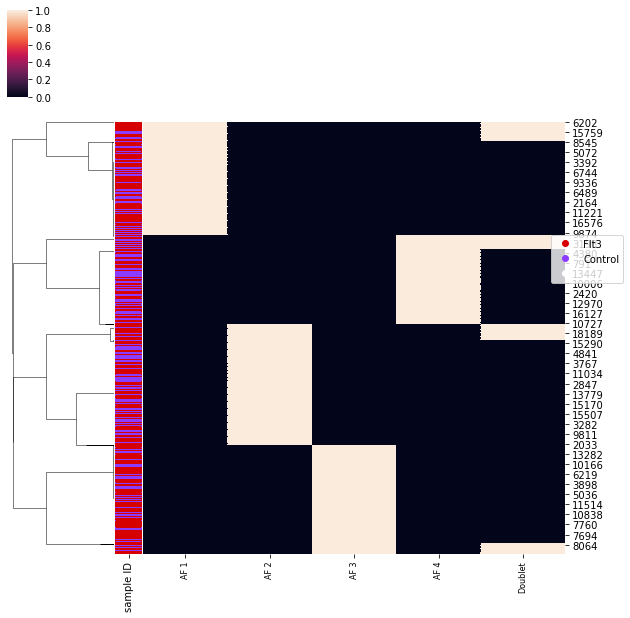

In [22]:
clust_df = pd.DataFrame(modelCA.ID_prob+np.random.uniform(low=0.0, high=0.0000005, size=modelCA.ID_prob.shape),
                       columns=[f"AF {x+1}" for x in np.arange(modelCA.ID_prob.shape[1])])
clust_df = pd.concat((clust_df,pd.DataFrame(doublet_prob, columns=["Doublet"])), axis=1)

ch.plot_cluster(clust_df, 
                to_row_clust=True, to_col_clust=False,
                row_meta=pd.DataFrame(sample_colors), to_legend=True, white_name=None)

plt.savefig(join(OUTDIR, "clusters_with_sampleIDs.png"))


## Save confident cell IDs in a line-separated text file for each cluster. Additionally, save AD and DP files. If mixed samples, create a sample id file as well for all the barcodes combined. 

In [24]:
prob_thresh=0.9
cell_clusters = dict()
#cell_clusters_names = dict()
for n in range(N_DONORS):
    # Drop low probability and/or high doublet probability
    cell_clusters[n] = np.flatnonzero((modelCA.ID_prob[:,n]>prob_thresh))
    cell_clusters[n] = cell_clusters[n][~(np.isin(cell_clusters[n], low_conf_cells))]
    #cell_clusters_names[n] = cells.loc[cell_clusters[n],0].values
    # Change the index to the sparse matrix index
    curr_ad = pd.DataFrame(AD.todense()[:, cell_clusters[n]]).reset_index().melt(id_vars='index', var_name="Cell", value_name="Count").rename({"index":"Position"}, axis=1)
    curr_dp = pd.DataFrame(DP.todense()[:, cell_clusters[n]]).reset_index().melt(id_vars='index', var_name="Cell", value_name="Count").rename({"index":"Position"}, axis=1)
    # Drop 0s
    curr_ad = curr_ad.loc[~(curr_ad["Count"]==0)]
    curr_dp = curr_dp.loc[~(curr_dp["Count"]==0)]
    
    #Update the map
    curr_cell_map = {val: ind+1 for ind,val in enumerate(np.sort(curr_dp["Cell"].unique()))}
    curr_pos_map = {val: ind+1 for ind,val in enumerate(np.sort(curr_dp["Position"].unique()))}
    #curr_ad["Cell"].map(curr_cell_map)
    curr_ad["Cell"] = curr_ad["Cell"].map(curr_cell_map)
    curr_ad["Position"] = curr_ad["Position"].map(curr_pos_map)
    curr_dp["Cell"] = curr_dp["Cell"].map(curr_cell_map)
    curr_dp["Position"] = curr_dp["Position"].map(curr_pos_map)
    
    print(f"Cluster {n}: {len(cell_clusters[n])} cells ")
    print(curr_dp.shape)
    print(curr_ad.shape)
    
    cell_clusters[n] += 1
    # Get their IDs 
    if OUTDIR != "" and exists(OUTDIR):
        curr_out = join(OUTDIR, f"cluster{n}_cells.txt")
        curr_str = "\n".join(cell_clusters[n].astype(str))
        with open(curr_out,"w") as f:
            f.write(curr_str)
        
        curr_ad_f = join(OUTDIR, f"cluster{n}.AD.txt")
        curr_dp_f = join(OUTDIR, f"cluster{n}.DP.txt")
        #curr_ad.to_csv(join(OUTDIR, f"cluster{n}.AD.txt"), sep="\t")
        #curr_dp.to_csv(join(OUTDIR, f"cluster{n}.DP.txt"), sep="\t")
        
        header = "%%MatrixMarket matrix coordinate integer general\n%\n"

        if os.path.exists(curr_ad_f):
            os.remove(curr_ad_f)
        if os.path.exists(curr_dp_f):
            os.remove(curr_dp_f)

        with open(curr_ad_f, 'a') as file:
            file.write(header)
            curr_ad = pd.concat((pd.DataFrame(
                {"Position": curr_ad["Position"].max(),
                 "Cell": curr_ad["Cell"].max(),
                 "Count": curr_ad.shape[0]}, index=["Meta"]),
                                 curr_ad.sort_values(["Position", "Cell"])), sort=False)
            curr_ad.to_csv(file, sep="\t", header=False, index=False)

        with open(curr_dp_f, 'a') as file:
            file.write(header)
            curr_dp = pd.concat((pd.DataFrame(
                {"Position": curr_dp["Position"].max(),
                 "Cell": curr_dp["Cell"].max(),
                 "Count": curr_dp.shape[0]}, index=["Meta"]),
                                 curr_dp.sort_values(["Position", "Cell"])))
            curr_dp.to_csv(file, sep="\t", header=False, index=False)

if OUTDIR!="":
    pd.DataFrame(AF_SNPs, columns = [f"Cluster {x}" for x in range(AF_SNPs.shape[1])]).to_csv(join(OUTDIR, "AF_SNPs.csv"), index=False)
cell_clusters

Cluster 0: 4118 cells 
(834055, 3)
(433196, 3)
Cluster 1: 4579 cells 
(927920, 3)
(453880, 3)
Cluster 2: 4305 cells 
(868072, 3)
(380878, 3)
Cluster 3: 3257 cells 
(664487, 3)
(314097, 3)


{0: array([    2,    11,    19, ..., 18877, 18879, 18882]),
 1: array([    3,     5,    10, ..., 18871, 18872, 18880]),
 2: array([    1,     4,     8, ..., 18873, 18883, 18884]),
 3: array([    6,     7,    12, ..., 18874, 18876, 18878])}

In [26]:
tot = 0
for i in cell_clusters.values():
    tot+=len(list(i))
tot

16259

### See if the N_DONOR satisfies the elbow loss rule
We can choose the number of clones where ELBO stops increasing. Here, the best number of clone is 3.

Note, for a certain number of clone, e.g., n_clone=3, the ELBO may not the same for multiple initializations. This is becaused VI can only guarantee a local optima, so please choose the highest ELBO for each `n_clone` to represent its "global" optima.

In [36]:
### Run lineage tracing for each cluster individually
def run_elbo(ad, dp, out_f="", n_clone_list=None, save_clusters=True):
    n_initials = 50


    if n_clone_list is None:
        n_clone_list = np.arange(2,5)
    _ELBO_mat = [] 
    for k in n_clone_list:
        print('lineages', k)
        _models_all = []
        _elbo_temp = []
        for i in range(50):
            _modelCA = Vireo(n_var=ad.todense().shape[0], n_cell=ad.todense().shape[1], n_donor=k, n_GT=2,
                             fix_beta_sum=False, ASE_mode=True)
            _modelCA.set_prior(beta_mu_prior=np.array([[0.01, 0.5]]))
            _modelCA.fit(ad, dp, min_iter=20, verbose=False)
            _elbo_temp.append(_modelCA.ELBO_[-1])
            _models_all.append(_modelCA)
            
        _ELBO_mat.append(_elbo_temp)
            
        # Run the plot_vireo_out
        ## Choose the model giving highest ELBO
        if save_clusters and not (out_f == ""):
            print('saving lineage tree for file:', out_f + f"clones{k}.lineages.png")
            _idx = np.argmax([x.ELBO_[-1] for x in _models_all])
            modelCA = _models_all[_idx]
            _losses = modelCA.ELBO_
            plot_vireo_out(modelCA, out_f=out_f+f"clones{k}.lineages.png")
            
    f = plt.figure()
    plt.boxplot(_ELBO_mat)
    plt.plot(np.arange(1,len(n_clone_list)+1), np.max(_ELBO_mat, axis=1))
    #plt.xticks(n_clone_list)
    plt.gca().set_xticklabels(n_clone_list)
    plt.ylabel("ELBO")
    plt.xlabel("n_clones")
    plt.show()
    if out_f != "":
        plt.savefig(out_f)
    
    return _ELBO_mat, n_clone_list


def plot_vireo_out(modelCA, out_f, to_sqrt=False):
    fig = plt.figure(figsize=(7, 4), dpi=100)
    plt.subplot(1, 2, 1)
    im = heat_matrix(modelCA.ID_prob, cmap="Oranges", alpha=0.8,
                     display_value=False, row_sort=True)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.title("Assignment probability")
    plt.xlabel("Clone")
    plt.ylabel("%d cells" %(modelCA.n_cell))
    plt.xticks(range(modelCA.n_donor))
    plt.subplot(1, 2, 2)
    AF_SNPs = np.sum(modelCA.GT_prob * 
                     np.expand_dims(modelCA.beta_mu, 1), axis=2)
    if to_sqrt:
        AF_SNPs = np.sqrt(AF_SNPs)
    im = heat_matrix(AF_SNPs, cmap="Blues", alpha=0.8, 
                     display_value=False, row_sort=True)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.title("Mean allelic ratio")
    plt.xlabel("Clone")
    plt.ylabel("%d SNPs" %(modelCA.n_var))
    plt.xticks(range(modelCA.n_donor))
    plt.tight_layout()
    plt.savefig(out_f)
    plt.show()
    return

2
3
4
5
6


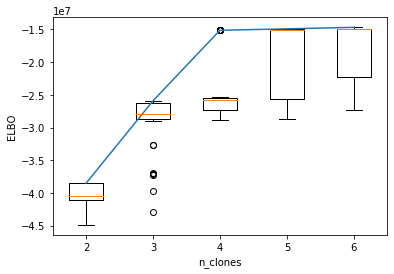

([[-40433281.40761244,
   -38506098.57539889,
   -41092382.05002504,
   -38505088.664518625,
   -41092138.63251711,
   -38804370.84546501,
   -38506203.19699219,
   -38505883.60594938,
   -38505264.284352824,
   -38803782.39287035,
   -38805397.73558385,
   -41092027.148015514,
   -38506099.56447671,
   -38506279.63661319,
   -38804245.84409004,
   -41092892.464051045,
   -38505818.83082299,
   -41091985.8608763,
   -42534238.85516803,
   -38505057.40339903,
   -41092668.631773904,
   -38804104.64722293,
   -40433852.04437803,
   -40434530.47046869,
   -41091893.133980155,
   -41099510.71398474,
   -38804169.48257175,
   -42533424.195074126,
   -40434037.927041814,
   -42534068.42004721,
   -41092814.413172916,
   -38506343.42998525,
   -41092389.29376424,
   -38505990.01041663,
   -41091706.287152804,
   -38506635.27185196,
   -40434015.1366277,
   -38506332.25229399,
   -42533798.17394425,
   -38804179.60061405,
   -38506160.062838115,
   -44887035.72575618,
   -41092079.393663555,
 

<Figure size 432x288 with 0 Axes>

In [29]:
run_elbo(AD, DP, out_f=join(OUTDIR, "elbow_plot.png"), n_clone_list=np.arange(N_DONORS-2, N_DONORS+3))

In [ ]:
# n_initials = 50
# n_clone_list = np.arange(N_DONORS-2, N_DONORS+3)

# _ELBO_mat = [] 
# for k in n_clone_list:
#     _elbo_temp = []
#     for i in range(50):
#         _modelCA = Vireo(n_var=AD_shape[0], n_cell=AD_shape[1], n_donor=k, n_GT=2,
#                          fix_beta_sum=False, ASE_mode=True)
#         _modelCA.set_prior(beta_mu_prior=np.array([[0.01, 0.5]]))
#         _modelCA.fit(AD, DP, min_iter=20, verbose=False)
#         _elbo_temp.append(_modelCA.ELBO_[-1])
#     _ELBO_mat.append(_elbo_temp)

# plt.boxplot(_ELBO_mat)
# plt.plot(np.arange(1,len(n_clone_list)+1), np.max(_ELBO_mat, axis=1))
# #plt.xticks(n_clone_list)
# plt.gca().set_xticklabels(n_clone_list)
# plt.ylabel("ELBO")
# plt.xlabel("n_clones")
# plt.show()

## Run each lineage separately

Cluster 0
lineages 2
saving lineage tree for file: data/jan21_2021/chrM/pseudo/minC200_minAF0.01/numC25000_ispropFalse/flt3/cluster0_lineage_elbow.pngclones2.lineages.png


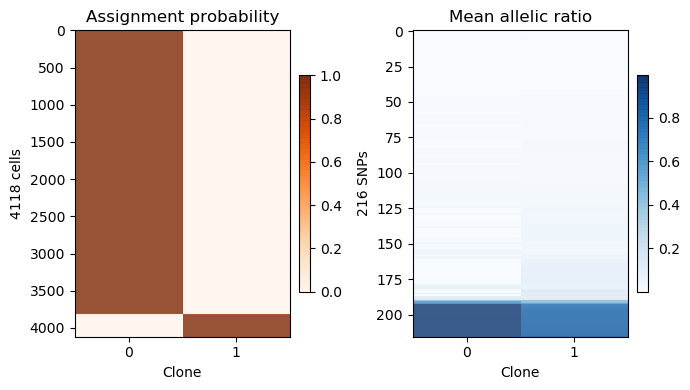

lineages 3
saving lineage tree for file: data/jan21_2021/chrM/pseudo/minC200_minAF0.01/numC25000_ispropFalse/flt3/cluster0_lineage_elbow.pngclones3.lineages.png


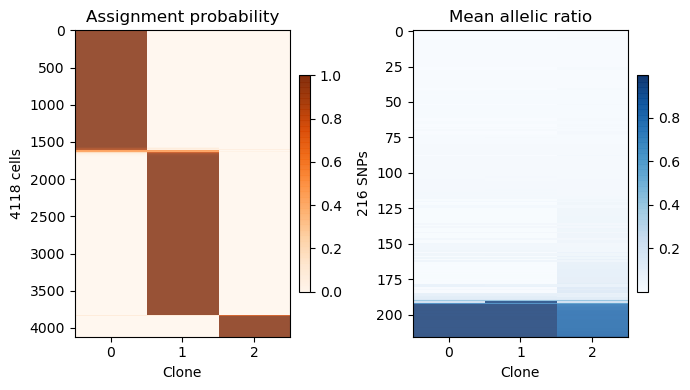

lineages 4
saving lineage tree for file: data/jan21_2021/chrM/pseudo/minC200_minAF0.01/numC25000_ispropFalse/flt3/cluster0_lineage_elbow.pngclones4.lineages.png


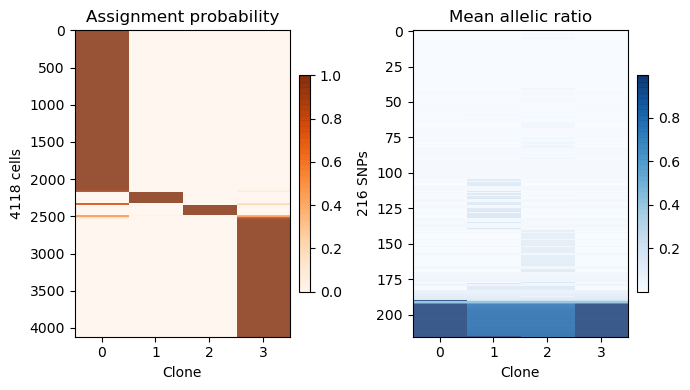

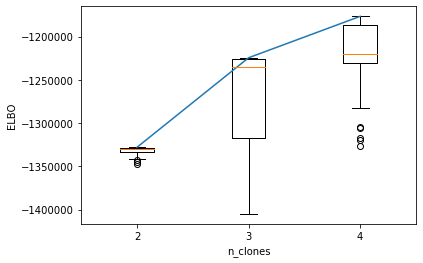

Cluster 1
lineages 2
saving lineage tree for file: data/jan21_2021/chrM/pseudo/minC200_minAF0.01/numC25000_ispropFalse/flt3/cluster1_lineage_elbow.pngclones2.lineages.png


<Figure size 432x288 with 0 Axes>

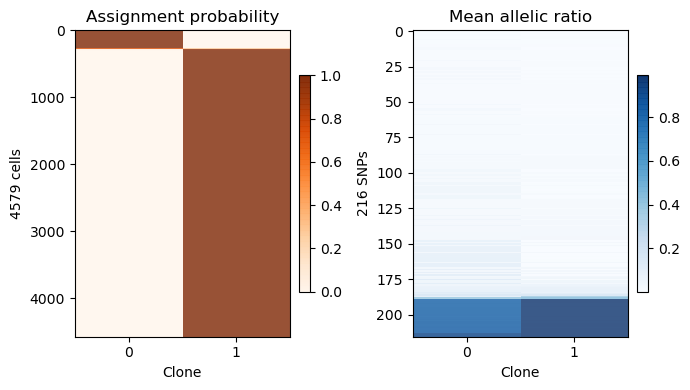

lineages 3
saving lineage tree for file: data/jan21_2021/chrM/pseudo/minC200_minAF0.01/numC25000_ispropFalse/flt3/cluster1_lineage_elbow.pngclones3.lineages.png


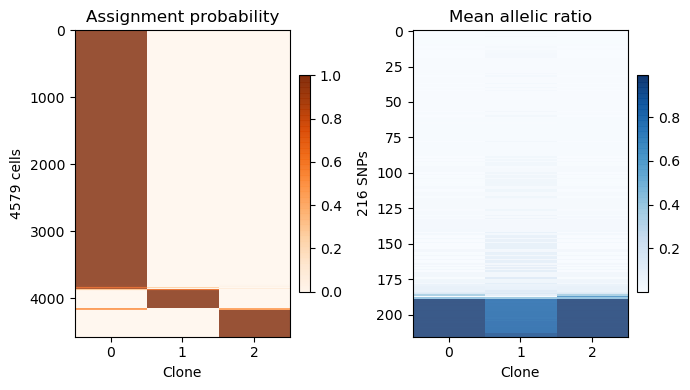

lineages 4
saving lineage tree for file: data/jan21_2021/chrM/pseudo/minC200_minAF0.01/numC25000_ispropFalse/flt3/cluster1_lineage_elbow.pngclones4.lineages.png


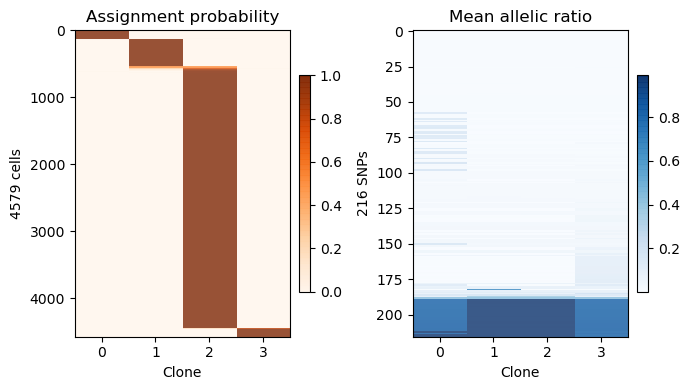

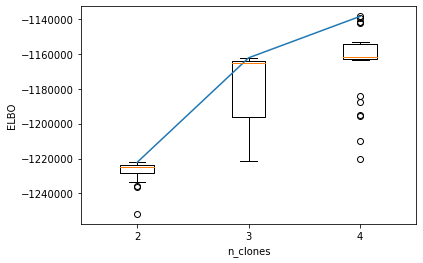

Cluster 2
lineages 2
saving lineage tree for file: data/jan21_2021/chrM/pseudo/minC200_minAF0.01/numC25000_ispropFalse/flt3/cluster2_lineage_elbow.pngclones2.lineages.png


<Figure size 432x288 with 0 Axes>

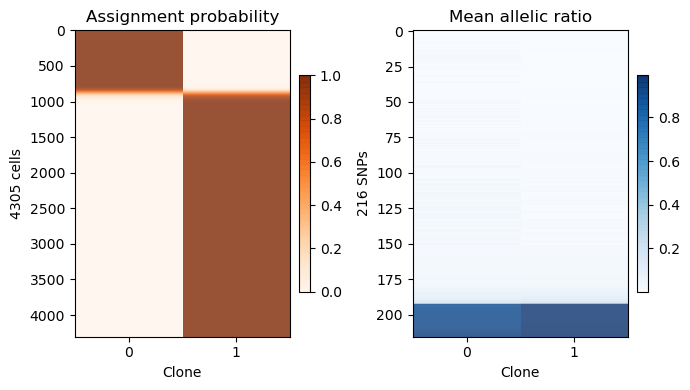

lineages 3
saving lineage tree for file: data/jan21_2021/chrM/pseudo/minC200_minAF0.01/numC25000_ispropFalse/flt3/cluster2_lineage_elbow.pngclones3.lineages.png


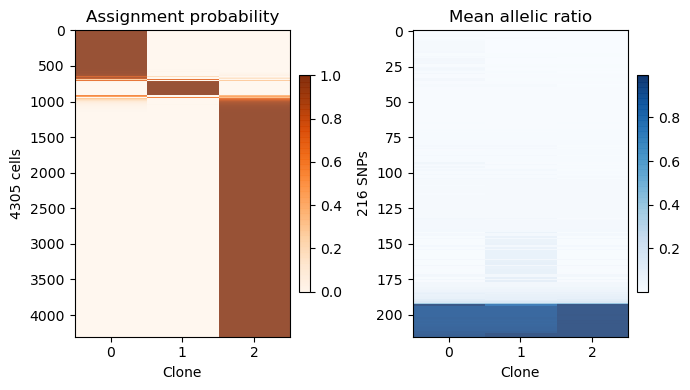

lineages 4
saving lineage tree for file: data/jan21_2021/chrM/pseudo/minC200_minAF0.01/numC25000_ispropFalse/flt3/cluster2_lineage_elbow.pngclones4.lineages.png


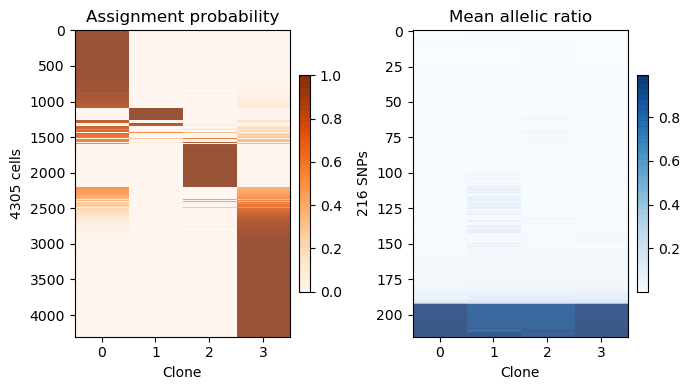

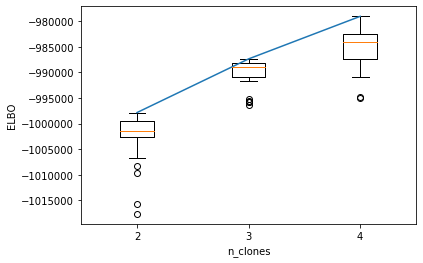

Cluster 3
lineages 2
saving lineage tree for file: data/jan21_2021/chrM/pseudo/minC200_minAF0.01/numC25000_ispropFalse/flt3/cluster3_lineage_elbow.pngclones2.lineages.png


<Figure size 432x288 with 0 Axes>

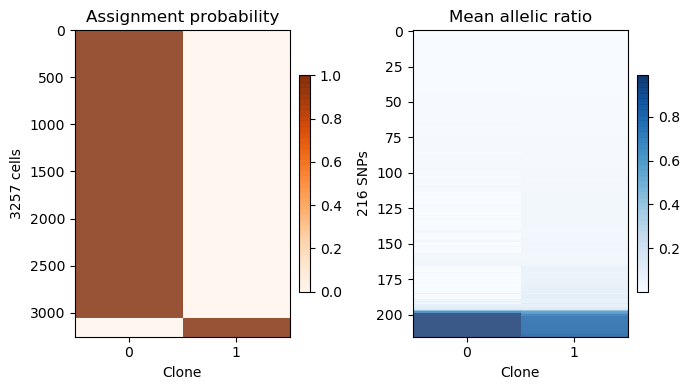

lineages 3
saving lineage tree for file: data/jan21_2021/chrM/pseudo/minC200_minAF0.01/numC25000_ispropFalse/flt3/cluster3_lineage_elbow.pngclones3.lineages.png


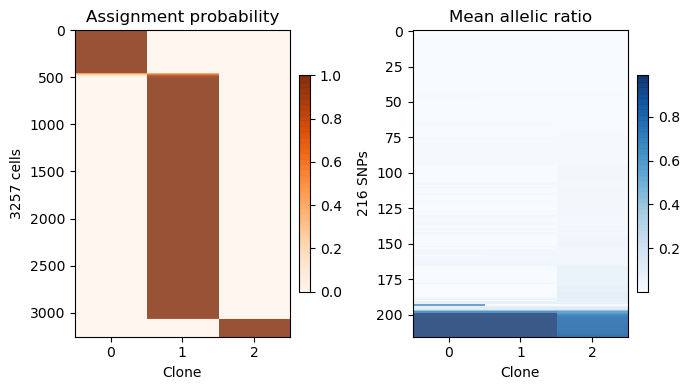

lineages 4
saving lineage tree for file: data/jan21_2021/chrM/pseudo/minC200_minAF0.01/numC25000_ispropFalse/flt3/cluster3_lineage_elbow.pngclones4.lineages.png


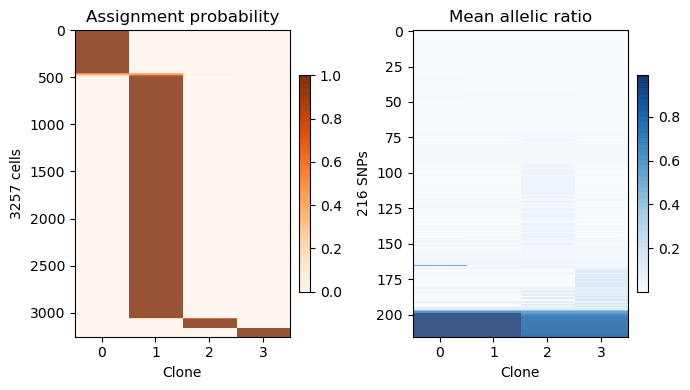

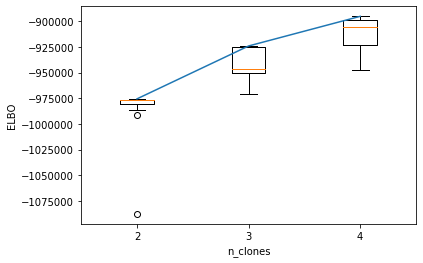

<Figure size 432x288 with 0 Axes>

In [38]:
for n in range(N_DONORS):
    print('Cluster', n)
    curr_ad_f = join(OUTDIR, f"cluster{n}.AD.txt")
    curr_dp_f = join(OUTDIR, f"cluster{n}.DP.txt")
    curr_ad = mmread(curr_ad_f).tocsc()
    curr_dp = mmread(curr_dp_f).tocsc()
    run_elbo(curr_ad, curr_dp, join(OUTDIR, f"cluster{n}_lineage_elbow.png"), n_clone_list=[2,3,4],
             save_clusters=True )

